<a href="https://colab.research.google.com/github/restrepo/articles_COVID-19/blob/master/lens_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lens API search for Coronavirus in Lens

Check: https://docs.api.lens.org/request.html

Get token: https://www.lens.org/lens/user/subscriptions

Examples: https://github.com/cambialens/lens-api-doc

## Functions and global variables

In [38]:
import getpass
import pandas as pd
import requests
import sys
import time
import os
import datetime
if os.getcwd()=='/content':
    !pip install unidecode
    !mkdir data
import unidecode    

mkdir: cannot create directory ‘data’: File exists


<!-- #mmkP9Ibp7bDpLNLKZF8bdYDxCQmxXhFuJzJViVKH92kyBlGmatE2
 -->

In [39]:
token=getpass.getpass('token:')

token:··········


In [0]:
url = 'https://api.lens.org/scholarly/search'
size=1000

In [0]:
def query(**kwargs):
    """
    WARNING: Accents needs to be removed!
    """
    key=list(kwargs.keys())[0]
    q=unidecode.unidecode(kwargs[key])
    #Set default values
    if not kwargs.get('size'):
        kwargs['size']=1000
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
           "match_phrase":{
                    "%s": "%s"
               }
           },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(key,q,kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data

def get_query(**kwargs):
    token=kwargs.get('token')
    url=kwargs.get('url')
    kk=kwargs.pop('url')
    kk=kwargs.pop('token')
    data=query(**kwargs)
    headers = {'Authorization': '{}'.format(token), 'Content-Type': 'application/json'}
    response = requests.post(url, data=data, headers=headers)
    if response.status_code != requests.codes.ok:
        print(response.status_code)
        r='[]'
    else:
        r=response.text
    return pd.read_json(r)    

def query_title(title="Dark Matter",range_type="date_published",
          date_ini="1900-01-01",
          date_end="2004-12-31",size=1000):
    """
    WARNING: Accents needs to be removed!
    """
    title=unidecode.unidecode(title)
    if range_type=="year_published":
        date_ini=date_ini.split('-')[0]
        date_end=date_end.split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
           "match_phrase":{
                    "title": "%s"
               }
           },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(title,range_type,date_ini,date_end,size)
    return data

In [0]:
RELOAD=False
rr=pd.DataFrame()
start_date=datetime.datetime.strptime('1900-01-01','%Y-%m-%d')
today=datetime.datetime.today()
for d in ['2020-03-05','2020-03-18',today.strftime('%Y-%m-%d')]:
    if not RELOAD:
        break
    next_date=datetime.datetime.strptime(d,'%Y-%m-%d')
    if next_date.date()==today.date():
        rr.to_json('data/covid_19_{}.json.gz'.format(
             (start_date-datetime.timedelta(days=1)).strftime('%Y-%m-%d')   ))

    print('{} → {} : '.format( start_date.strftime('%Y-%m-%d'),
                              next_date.strftime('%Y-%m-%d') ),
          end='')
    data=query_title(title="covid-19",
      range_type="date_published",
      date_ini=start_date.strftime('%Y-%m-%d'),
      date_end=next_date.strftime('%Y-%m-%d'),
      size=1000) 

    start_date=next_date+datetime.timedelta(days=1)
    headers = {'Authorization': '{}'.format(token), 'Content-Type': 'application/json'}
    response = requests.post(url, data=data, headers=headers)
    if response.status_code != requests.codes.ok:
        print(response.status_code)
        r='[]'
    else:
        r=response.text
    tmp=pd.read_json(r)
    print(tmp.shape)
    rr=rr.append( tmp  ).reset_index(drop=True)
    time.sleep(5)

### Check results

In [0]:
if RELOAD:
    cv=pd.DataFrame(list(rr.data.values))
    cv.to_json('data/covid_19.json.gz')
else:
    urljason='https://github.com/restrepo/lensapi/raw/master/data/covid_19.json.gz'
    cv=pd.read_json(urljason,compression='gzip')

In [8]:
cv.shape

(2923, 30)

In [0]:
cv.to_json('data/covid_19.json.gz')


In [0]:
cv.scholarly_citations_count.sum()

732.0

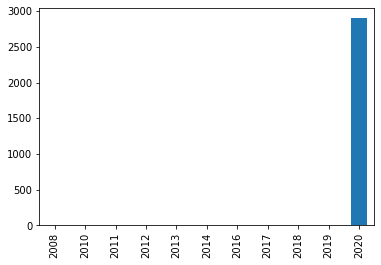

In [0]:
cv['Year']=cv.date_published.apply(lambda s: s.split('-')[0] if type(s)==str else 
                                          s.get('date').split('-')[0] )
cv=cv[~cv['Year'].isna()].reset_index(drop=True)
cv['Year']=cv['Year'].astype(int)
cv[cv['Year']>2007]['Year'].value_counts().sort_index().plot(kind='bar')

### Search for citations

In [109]:
get_query(lens_id='100-004-910-081-14X',url=url,token=token)

ERROR! Session/line number was not unique in database. History logging moved to new session 63


,total,data,results
0,1,{'patent_citations': [{'lens_id': '066-596-872...,1


In [112]:
cv['scholarly_citations']

0                                                    None
1              [031-883-225-563-477, 041-669-833-363-319]
2       [003-127-464-982-370, 014-541-219-035-444, 015...
3                                                    None
4                                                    None
                              ...                        
2918                                                 None
2919                                                 None
2920                                                 None
2921                                                 None
2922                                                 None
Name: scholarly_citations, Length: 2923, dtype: object

In [114]:
get_query(lens_id='031-883-225-563-477',url=url,token=token)

,total,data,results
0,1,"{'lens_id': '031-883-225-563-477', 'created': ...",1
